<dev style="text-align: center;">
    <h1><strong>NARUTO CHATTER</strong></h1>
    <div style="display: flex; justify-content: center;">
        <img src='img1.webp'>
    </dev>
</dev>

In [1]:
import os
from dotenv import load_dotenv
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader, PyPDFLoader
from langchain_chroma import Chroma
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain.prompts import PromptTemplate
from langchain_core.messages import AIMessage, HumanMessage
from langchain.schema import BaseMessage
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from typing import List
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START
from langchain_core.language_models.llms import LLM
import requests
import json
import re

DB = "db"
CHROMA_DB = "chroma_db"
DB_COLLECTION_NAME = "rag-AI-Agent-chroma"
EMBEDDING =  "sentence-transformers/multi-qa-mpnet-base-dot-v1"
QUERY = "query"
GENERATION = "generation"
DOCUMENTS = "documents"
DOCUMENT = "document"
CHAT_HISTORY = "chat_history"
QUERY_TRANSFORMATION_ATTEMPTS = "query_transformation_attempts"
GENERATION_ATTEMPTS = "generation_attempts"

load_dotenv()

USER_AGENT environment variable not set, consider setting it to identify your requests.


True

## Index

In [2]:
urls = [
    'https://en.wikipedia.org/wiki/Naruto',
    'https://naruto.fandom.com/wiki/Naruto_Uzumaki'
]

In [3]:
current_dir = os.path.curdir
persistence_directory = os.path.join(current_dir, DB, CHROMA_DB)
embedding = HuggingFaceEmbeddings(model_name =EMBEDDING)

if not os.path.exists(persistence_directory):
    print("persistent directory does not exist, Initializing vector store...")

    docs = [WebBaseLoader(url).load() for url in urls]
    docs_list = [item for sublist in docs for item in sublist]

    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=800, chunk_overlap=150)
    doc_splits = text_splitter.split_documents(docs_list)

    db = Chroma.from_documents(
        documents=doc_splits,
        collection_name=DB_COLLECTION_NAME,
        embedding=embedding,
        persist_directory=persistence_directory
    )
    
else:
    db = Chroma(persist_directory=persistence_directory, embedding_function=embedding, collection_name=DB_COLLECTION_NAME)



retriever = db.as_retriever(search_type='similarity', search_kwargs={'k':3})

persistent directory does not exist, Initializing vector store...


## LLM

##### Lama-3.1-8B-Instruct-ustom

In [4]:
class llm_model(LLM):

    api_key: str = os.getenv("CUSTOM_LLM_API_KEY")
    llm_uri: str = os.getenv("CUSTOM_LLM_URI")
    temperature: float = 0.0
    top_p: float = 0.9
    max_tokens: int = 512
        
    @property
    def _llm_type(self) -> str:
        return "custom-llm-model"
    
    def _call(self, prompt: str, stop):

        payloads = {
            "prompt": prompt,
            "temperature": self.temperature,
            "top_p": self.top_p,
            "max_tokens": self.max_tokens,
        }

        headers = {
            "Content-Type": "application/json",
            "X-API-KEY": self.api_key
        }

        response = requests.post(self.llm_uri, json=payloads, headers=headers)
        if response.status_code != 200:
            raise Exception(f"Request failed with status {response.status_code}: {response.text}")
        result = response.json().get("generate_text", "---NO_GENERATED_TEXT---")
        pattern = r'\n\s*\n\s*assistant\s*\n'
        matches = list(re.finditer(pattern, result, re.DOTALL))
        if matches:
            last_match = matches[-1]
            extracted = result[last_match.end():]
            return extracted
        else:
            print("Pattern not found")
            raise Exception("---FAILED TO RETRIEVE THE PATTERN FROM LLM RESPONSE---")


##### Query Retreiving Grader

In [5]:
llm_query_retreiver_grader = llm_model(temperature=0.3)

prompt_query_retrieving_grader = PromptTemplate(
    template="""
        <|begin_of_text|>
        <|start_header_id|>system<|end_header_id|>
        You are a query evaluator. Given the current query or task, assess its relevance to the historical context or previous interactions.
        
        Rules:
        - If `chat_history` is empty, classify the query as "unrelated" (there is no context).
        - If the query is independent and has no direct connection to the historical context, classify it as "unrelated".
        - If the query builds upon or references the historical context, or is solely about recalling past conversations, classify it as "history".
        - If the relationship between the query and the historical context is unclear, classify it as "ambiguous".
        
        Respond only with a JSON object containing a single key "next_node". Do not include any additional text or explanation.
        Output format: {{"next_node": "unrelated"}} or {{"next_node": "history"}} or {{"next_node": "ambiguous"}}
        <|eot_id|>
        
        <|start_header_id|>user<|end_header_id|>
        Chat_history: {chat_history}
        Query: {query}
        <|eot_id|>
        
        <|start_header_id|>assistant<|end_header_id|>
        
    """.strip(), input_variables=[QUERY, CHAT_HISTORY]
)

query_retreiver_grader = prompt_query_retrieving_grader | llm_query_retreiver_grader | JsonOutputParser()

##### History Query Relevence Grader

In [6]:
llm_history_query_grader = llm_model(temperature=0.3)

prompt_history_query_grader = PromptTemplate(
    template="""
        <|begin_of_text|>
        <|start_header_id|>system<|end_header_id|>
        You are a query evaluator. Given the current query or task, determine whether the query is solely about recalling past conversations or if it builds upon the historical context with new elements.
        
        Rules:
        - If the query is solely about recalling past conversations without introducing new topics, classify it as "history_only".
        - If the query builds upon or references the historical context with new elements, classify it as "related".
        
        Respond only with a JSON object containing a single key "next_node". Do not include any additional text or explanation.
        Output format: {{"next_node": "history_only"}} or {{"next_node": "related"}}
        <|eot_id|>
        
        <|start_header_id|>user<|end_header_id|>
        Chat_history: {chat_history}
        Query: {query}
        <|eot_id|>
        
        <|start_header_id|>assistant<|end_header_id|>
        
    """.strip(), input_variables=[QUERY, CHAT_HISTORY]
)

history_query_grader = prompt_history_query_grader | llm_history_query_grader | JsonOutputParser()

##### History Only Responder

In [7]:
llm_history_responder = llm_model(temperature=0.3)

prompt_history_responder = PromptTemplate(
    template="""
        <|begin_of_text|>
        <|start_header_id|>system<|end_header_id|>
        The user is inquiring about past conversations they've had.

        Your task is to summarize the relevant past interactions clearly and concisely.
        Make sure the user feels acknowledged and that their past input is respected.
        Example responses:
        - "Previously, you mentioned that..."
        - "In our last conversation, you discussed..."
        - "You asked about X before, and here's what was covered..."

        Be polite and ensure the response is reflective of the user's past contributions.
        <|eot_id|>

        <|start_header_id|>user<|end_header_id|>
        Chat_history: {chat_history}
        Query: {query}
        <|eot_id|>

        <|start_header_id|>assistant<|end_header_id|>
        
    """.strip(), input_variables=[QUERY, CHAT_HISTORY]
)

history_responder = prompt_history_responder | llm_history_responder | StrOutputParser()

#### Ambiguous responder

In [8]:
llm_ambiguous_responder = llm_model(temperature=0.3)

prompt_ambiguous_responder = PromptTemplate(
    template="""
        <|begin_of_text|>
        <|start_header_id|>system<|end_header_id|>
        The current query or task has been determined to have an ambiguous relationship with the historical context.
        As the "ambiguous_responder," provide a clear and helpful response to the user that acknowledges the ambiguity and offers guidance.
        The response should be polite and suggest next steps or clarifications to help resolve the uncertainty. For example:
        "It seems there’s some uncertainty about the relevance of this query to previous information. Could you please provide more context or clarify your request?"
        "I'm not entirely sure how this query relates to prior context. Can you help me understand the connection better?"
        "The relationship between the current task and previous data isn't fully clear. Can you give me more details?"
        Your goal is to help the user refine their query or provide further context, ensuring they feel supported despite the ambiguity.
        <|eot_id|>

        <|start_header_id|>user<|end_header_id|>
        Chat_history: {chat_history}
        Query: {query}
        <|eot_id|>

        <|start_header_id|>assistant<|end_header_id|>
    """.strip(), input_variables=[QUERY]
)

ambiguous_responder = prompt_ambiguous_responder | llm_ambiguous_responder | StrOutputParser()

##### Retriever Grader

In [9]:
llm_retriever_grader = llm_model(temperature=0.3)

prompt_retriever_grader = PromptTemplate(
    template="""
        <|begin_of_text|>
        <|start_header_id|>system<|end_header_id|>
        You are a grader assessing the relevance of a retrieved document to a user query.
        Assess whether the content of the document effectively addresses the user's intent.
        Respond only with a JSON object containing a single key 'score' with a value of 'yes' or 'no'. Do not include any additional text or explanation.
        Output format: `{{"score": "yes"}}` or `{{"score": "no"}}`
        <|eot_id|>
        
        <|start_header_id|>user<|end_header_id|>
        Here is the retrieved document:
        {document}
        Query:
        {query}
        <|eot_id|>
        
        <|start_header_id|>assistant<|end_header_id|>

""".strip(),
    input_variables=[QUERY, DOCUMENT],
)

retriever_grader = prompt_retriever_grader | llm_retriever_grader | JsonOutputParser()

##### Query Re-writer

In [10]:
llm_query_rewriter = llm_model(temperature=0.3)

prompt_query_rewriter = PromptTemplate(
    template="""
        <|begin_of_text|>
        <|start_header_id|>system<|end_header_id|>
        You are a query re-writer tasked with improving the input query for better vectorstore retrieval performance.
        Your goal is to reformulate the query in a way that enhances its clarity, relevance, and retrieval accuracy, making it more suitable for the vector-based search system.
        Please provide an improved version of the query that is optimized for vectorstore retrieval, without any preamble or explanation.
        <|eot_id|>

        <|start_header_id|>user<|end_header_id|>
        Query: {query}
        <|eot_id|>

        <|start_header_id|>assistant<|end_header_id|>
        
    """.strip(),
    input_variables=[QUERY],
)

query_rewriter = prompt_query_rewriter | llm_query_rewriter | StrOutputParser()

##### Contextualizer

In [11]:
llm_contextualizer = llm_model(temperature=0.3)

prompt_contextualizer = PromptTemplate(
    template="""
        <|begin_of_text|>
        <|start_header_id|>system<|end_header_id|>
        You are an AI that reformulates user queries based on chat history to make them standalone.
        Your task is to resolve references, pronouns, and vague descriptions using prior interactions.
        Ensure the reformulated question is clear, precise, and contains all necessary details for retrieval. 
        If no relevant context exists in the chat history, return the question as is. 
        Do NOT explain, introduce, or provide reasoning—just return the reformulated query with NO preamble.
        <|eot_id|>

        <|start_header_id|>user<|end_header_id|>
        Chat_history: {chat_history}
        Query: {query}
        <|eot_id|>
        
        <|start_header_id|>assistant<|end_header_id|>

    """.strip(), input_variables=[QUERY, CHAT_HISTORY]
)

contextualizer = prompt_contextualizer | llm_contextualizer | StrOutputParser()

##### Generater

In [12]:
llm_generator = llm_model(temperature=0.3)

prompt_generator = PromptTemplate(
    template="""
        <|begin_of_text|>
        <|start_header_id|>system<|end_header_id|>
        You are an assistant tasked with answering queries related to Naruto Anime.
        If the answer is available in the documents, provide a concise and clear response starting with:        
        If the answer is not found in the documents, simply say:
        "I don't know."
        Always end your response with:
        Ensure your answer is concise, clear, and informative, without being overly brief.
        <|eot_id|>

        <|start_header_id|>user<|end_header_id|>
        Use the following pieces of documents to formulate your response.
        Documents: {documents}
        The following is the chat history
        Chat_history: {chat_history}
        Query: {query}
        <|eot_id|>

        <|start_header_id|>assistant<|end_header_id|>

""".strip(), input_variables=[DOCUMENTS, CHAT_HISTORY, QUERY])


generator = prompt_generator | llm_generator | StrOutputParser()

##### Hallucination Grader

In [13]:
llm_hallucination_grader = llm_model(temperature=0.3)

hallucination_grader_prompt = PromptTemplate(
    template="""
        <|begin_of_text|>
        <|start_header_id|>system<|end_header_id|>
        You are a grader tasked with assessing whether the provided answer is grounded in or supported by the given set of facts.

        Please provide a binary score:
        'yes' if the answer is supported by the facts.
        'no' if the answer is not supported by the facts.
        
        Return the score in JSON format with the key 'score', without any explanation or additional commentary.
        <|eot_id|>

        <|start_header_id|>user<|end_header_id|>
        Facts: {documents}
        Answer: {generation}
        <|eot_id|>

        <|start_header_id|>assistant<|end_header_id|>
        
    """.strip(),
    input_variables=[GENERATION, DOCUMENTS],
)

hallucination_grader = hallucination_grader_prompt | llm_hallucination_grader | JsonOutputParser()

##### Answer Grader

In [14]:
llm_answer_grader = llm_model(temperature=0.3)

answer_grader_prompt = PromptTemplate(
    template="""
        <|begin_of_text|>
        <|start_header_id|>system<|end_header_id|>
        you are a grader tasked with evaluating whether the provided answer is useful in resolving the given query.

        Please provide a binary score:
        'yes' if the answer is useful in resolving the question.
        'no' if the answer is not useful.
        
        Return the score in JSON format with the key 'score', without any explanation or additional commentary.
        <|eot_id|>

        <|start_header_id|>user<|end_header_id|>
        Answer:{generation}
        Query: {query}
        <|eot_id|>

        <|start_header_id|>assistant<|end_header_id|>
        
    """.strip(),
    input_variables=[GENERATION, QUERY],
)

answer_grader = answer_grader_prompt | llm_answer_grader | JsonOutputParser()

## Graph State

In [15]:
class GraphState(TypedDict):
    """
    Represent the state of the graph

    Attributes:
        query: query
        generation: LLM generation
        documents: list of documents
        chat_history: chat history
        attempts: number of attempts
    """

    query: str
    generation: str
    documents: List[str]
    chat_history: List[str]
    query_transformation_attempts: int
    generation_attempts: int

## Graph Details

### Nodes

#### Query Retreiving Check Node

In [16]:
def check_query_retreiving(state):
    """
    Check query retreiving
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Return query and chat_history
    """

    print("---CHECK QUERY RETREIVING---")
    return state

#### History Relevant Check Node

In [17]:
def check_history_relevant(state):
    """
    Check history relevant

    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Return query and chat_history
    """

    print("---CHECK CHAT HISTORY RELEVANT---")
    return state

#### Contextualize Node

In [18]:
def contextualize(state):
    """
    Contextualize query

    Args:
        state (dict): the current graph state
    Returns:
        state (dict): Update the query based on chat history
    """

    print("---CONTEXTUALIZE---")
    query = state[QUERY]
    chat_history = state[CHAT_HISTORY]

    contextualized_query = contextualizer.invoke(
        {
            QUERY: query,
            CHAT_HISTORY: chat_history
        }
    )
    print(contextualized_query)
    state[QUERY] = contextualized_query
    return state

#### Retrieve Node

In [19]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """

    print("---RETRIEVE---")
    query = state[QUERY]

    documents = retriever.invoke(query)
    state[DOCUMENTS] = documents
    return state

#### Filterate Documents

In [20]:
def filterate_documents(state):
    """
    Fitlerate relveant documetns

    Args:
        state (dict): The current state graph
    Returns:
        state (dict): State with updaed documetns
    """
    print("---CHECK DOCUMENTS RELEVANCE TO QUERY---")
    query = state[QUERY]
    documents = state[DOCUMENTS]

    filtered_docs = []
    for d in documents:
        score = retriever_grader.invoke(
            {
                QUERY: query,
                DOCUMENT: d
            }
        )

        grade = score["score"]
        if grade == 'yes':
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    
    state[DOCUMENTS] = filtered_docs
    return state

#### History Only Responder

In [21]:
def history_only_respond(state):
    """
    Generate history only answer

    Args:
        state (dict): The current graph state
    Returns:
        state (dict): new key added to state, that contains LLM generation for history only
    """

    print("---GENERATE HISTORY ONLY ANSWER---")
    query = state[QUERY]
    chat_history = state[CHAT_HISTORY]
    
    history_only_generation = history_responder.invoke(
        {
            QUERY: query,
            CHAT_HISTORY: chat_history
        }
    )
    state[GENERATION] = history_only_generation
    return state

#### Ambiguous Responder Node

In [22]:
def ambiguous_respond(state):
    """
    Generate ambiguity anwer

    Args:
        state (dict): The current graph state
    Returns:
        state (dict): new key added to state, that contains LLM generation for ambiguity
    """

    print("---GENERATE AMBIGUITY ANSWER---")
    query = state[QUERY]
    chat_history = state[CHAT_HISTORY]
    
    ambiguity_generation = ambiguous_responder.invoke(
        {
            QUERY: query,
            CHAT_HISTORY: chat_history
        }
    )
    state[GENERATION] = ambiguity_generation
    return state

#### Decrease Query Transformation Attemtps Node

In [23]:
def decrease_query_transformation_attempts(state):
    """
    Decrease the attempts of query transformation

    Args:
        state (dict): The current state
    Returns:
        state (dic): Increase the number of query_transformation_attempts
    """

    print(f'---DECREASE_{QUERY_TRANSFORMATION_ATTEMPTS}---')
    attempts = state[QUERY_TRANSFORMATION_ATTEMPTS]
    if attempts== 0:
        print(f'QUERY_TRANSFORMATION_ATTEMPTS: {attempts}')
        return state
    else:
        state[QUERY_TRANSFORMATION_ATTEMPTS]=attempts-1
        print(f'QUERY_TRANSFORMATION_ATTEMPTS: {attempts}')
        return state

#### Query Transformtion Attempts Checking Node

In [24]:
def check_query_transformation_attempts(state):
    """
    Check the number of query transformation attempts.

    Args:
        state (dict): The current state graph
    Returns:
        state (dict): The current state graph.
    """

    print("---CHECK_QUERY_TRANSFORAMTION_ATTEMPS_NUMBER---")
    return state

#### Transform Query Node

In [25]:
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current state
    Returns:
        state (dict): Updates query key with a re-phrased query
    """

    print("---TRANSFORM QUERY---")
    query = state[QUERY]

    better_query = query_rewriter.invoke({
        QUERY:query
    })

    state[QUERY] = better_query
    print("TRANSFORMED_QUERY: ", better_query)
    return state

#### Decrease Generation Attemtps Node

In [26]:
def decrease_generation_attempts(state):
    """
    Decrease the attempts of generation

    Args:
        state (dict): The current state
    Returns:
        state (dic): Increase the number of generation_attempts
    """

    print(f'---DECREASE_{GENERATION_ATTEMPTS}---')
    attempts = state[GENERATION_ATTEMPTS]
    if attempts == 0:
        print(f'GENERATION_ATTEMPTS: {attempts}')
        return state
    else:
        state[GENERATION_ATTEMPTS]= attempts - 1
        print(f'GENERATION_ATTEMPTS: {attempts}')
        return state

#### Generation Attempts Checking Node

In [27]:
def check_generation_attempts(state):
    """
    Check the number of generation attempts.

    Args:
        state (dict): The current state graph
    Returns:
        state (dict): The current state graph.
    """

    print("---CHECK_Generation_ATTEMPS_NUMBER---")
    return state

#### Generate Node

In [28]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): the current graph state
    Returns:
        state (dict): new key added to state, that contains LLM generation
    """

    print("---GENERATE---")
    query = state[QUERY]
    documents = state[DOCUMENTS]
    chat_history = state[CHAT_HISTORY]

    generation = generator.invoke(
        {
            DOCUMENTS: documents,
            CHAT_HISTORY: chat_history,
            QUERY: query
        }
    )
    state[GENERATION] = generation
    return state

#### Not Support Node

In [29]:
def get_not_support_state(state):
    """
    get not support state

    Args:
        state (dict): the current graph state
    Returns:
        state (dict): Not support state Data
    """

    print("---COULD NOT DO IT---")
    generation = "I could not do it, Please try again." #TODO need to Change

    state[GENERATION] = generation
    return state

### Edges

##### Decide Node to Call Based on Query Retreive Grade

In [30]:
def decide_node_to_call_based_on_query_retreive_grade(state):
    """
    Determines whether to move to 'Retrive', 'History" or Ambiguous'

    Args:
        state (dict): The current graph state
    Returns:
        'Retrive', 'History" or ambiguous' for next code to call
    """

    print("---CHOOSE NEXT NODE TO CALL BASED ON QUERY RETREIVE GRADE---")
    query = state[QUERY]
    chat_history = state[CHAT_HISTORY]

    grade = query_retreiver_grader.invoke(
        {
            QUERY: query,
            CHAT_HISTORY: chat_history
        }
    )

    next_node = grade['next_node']
    if next_node == 'unrelated':
        print("---DECISION: QUERY IS NOT RELATED TO THE CHAT HISTORY---")
        return 'UNRELATED'
    elif next_node == 'history':
        print("---DECISION: QUERY IS RELATED TO THE CHAT HISTORY---")
        return 'HISTORY'
    elif next_node == 'ambiguous':
        print("---DECISION: QUERY IS AMBIGUOUS")
        return 'AMBIGUOUS'

#### Decide Node to Call Based on History Relevance

In [31]:
def decide_node_to_call_based_on_history_relevancy(state):
    """
    Determines whether to move to 'Retrive', 'Contextualize"

    Args:
        state (dict): The current graph state
    Returns:
        'Retrive', 'Contextualize" for next code to call
    """

    print("---CHOOSE NEXT NODE TO CALL BASED ON HISTORY RELEVANCY")
    query = state[QUERY]
    chat_history = state[CHAT_HISTORY]

    grade = history_query_grader.invoke(
        {
            QUERY: query,
            CHAT_HISTORY: chat_history
        }
    )

    next_node = grade['next_node']
    if next_node == 'related':
        print("---DECISION: QUERY IS RELATED TO THE CHAT HISTORY---")
        return 'RELATED'
    elif next_node == 'history_only':
        print("---DECISION: QUERY IS RELATED ONLY TO HISTORY---")
        return 'HISTORY_ONLY'

#### Check Query Transfomration Attempts Number

In [32]:
def choose_next_call_based_on_query_transformation_attempts(state):
    """
    Check the number of query transformation attempts, if equal zero,
    and return the next node to call based on that.

    Args:
        state (dict): The current state graph
    Returns:
        Next node to call
    """

    print("---CHOOSE_NEXT_NODE_BASED_ON_QUERY_TRANSFORMATION_ATTEMPS---")
    if state[QUERY_TRANSFORMATION_ATTEMPTS] <= 0:
        return "NOT_SUPPORT_RESPOND_GENERATING"
    else:
        return "QUERY_TRANSFORMING"


#### Check Generation Attempts Number

In [33]:
def choose_next_call_based_on_generation_attempts(state):
    """
    Check the number of generation attempts, if equal zero,
    and return the next node to call based on that.

    Args:
        state (dict): The current state graph
    Returns:
        Next node to call
    """

    print("---CHOOSE_NEXT_NODE_BASED_ON_GENERATION_ATTEMPS---")
    if state[GENERATION_ATTEMPTS] <= 0:
        print("---DECISION: NOT_SUPPORT_RESPOND_GENERATING")
        return "NOT_SUPPORT_RESPOND_GENERATING"
    else:
        print("---DECISION: GENERATION")
        return "GENERATION"


#### Decide to Generate    

In [34]:
def decide_to_generate(state):
    """
    Determines whether to generate an asnwer, or re-write a query.

    Args:
        state (dict): The current graph state
    Returns:
        Binary decision for next node to call 
    """
        
    print("---ASSESS GRADED DOCUMENTS---")
    state[QUERY]
    filtered_docs = state[DOCUMENTS]

    if not filtered_docs:
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUERY, DECREASE QT ATTEMPTS---")
        return "DECREASE_QT_ATTEMPTS"
    else:
        print("---DECISION: DECREASE GENERATION ATTEMPS---")
        return "DECREASE_GENERATION_ATTEMPS"


#### Grade Generation vs Documents and Query

In [35]:
def grade_generation_v_documents_and_query(state):
    """
    Determines whether the generation is frounded in the document and answers query.

    Args:
        state (dict): The current graph state
    Returns:
        Binary decision for next node to call
    """

    print("---CHECK HALLUCINATION---")
    query = state[QUERY]
    documents=state[DOCUMENTS]
    generation=state[GENERATION]

    score = hallucination_grader.invoke(
        {
            DOCUMENTS: documents,
            GENERATION: generation
        }
    )

    grade = score["score"]

    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        print("---GRADE GENERATION VS QUERY")
        score = answer_grader.invoke(
            {
                GENERATION:generation,
                QUERY:query
            }
        )

        grade = score["score"]
        if grade == "yes":
            print("DECISION: GENERATION ADDRESSES QUERY---")
            return "USEFUL"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUERY---")
            return "NOT_USEFUL"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "NOT_USEFUL"


## Graph Core

In [36]:
workflow = StateGraph(GraphState)

workflow.add_node("QUERY_RETREIVING_CHECKING", check_query_retreiving)
workflow.add_node("HISTORY_RELEVANT_CHECKING", check_history_relevant)
workflow.add_node("HISTORY_ONLY_GENERATING", history_only_respond)
workflow.add_node("AMBIGUOUS_RESPOND_GENERATING", ambiguous_respond)
workflow.add_node("CONTEXTUALIZING", contextualize)
workflow.add_node("RETRIEVING", retrieve)
workflow.add_node("DOCUMENTS_FILTERATING", filterate_documents)
workflow.add_node("DECREASE_QT_ATTEMPTS", decrease_query_transformation_attempts)
workflow.add_node("QT_ATTEMPTS_CHECKING", check_query_transformation_attempts)
workflow.add_node("DECREASE_GENERATION_ATTEMPS", decrease_generation_attempts)
workflow.add_node("GENERATION_ATTEMPTS_CHECKING", check_generation_attempts)
workflow.add_node("GENERATION", generate)
workflow.add_node("QUERY_TRANSFORMING", transform_query)
workflow.add_node("NOT_SUPPORT_RESPOND_GENERATING", get_not_support_state)

workflow.add_edge(START, "QUERY_RETREIVING_CHECKING")
workflow.add_conditional_edges(
    "QUERY_RETREIVING_CHECKING",
    decide_node_to_call_based_on_query_retreive_grade,
    {
        "UNRELATED": "RETRIEVING",
        "AMBIGUOUS": "AMBIGUOUS_RESPOND_GENERATING",
        "HISTORY": "HISTORY_RELEVANT_CHECKING",
    }
)

workflow.add_conditional_edges(
    "HISTORY_RELEVANT_CHECKING",
    decide_node_to_call_based_on_history_relevancy,
    {
        "RELATED": "CONTEXTUALIZING",
        "HISTORY_ONLY": "HISTORY_ONLY_GENERATING"
    }
)

workflow.add_edge("HISTORY_ONLY_GENERATING", END)
workflow.add_edge("AMBIGUOUS_RESPOND_GENERATING", END)

workflow.add_edge("CONTEXTUALIZING", "RETRIEVING")
workflow.add_edge("RETRIEVING", "DOCUMENTS_FILTERATING")

workflow.add_conditional_edges(
    "DOCUMENTS_FILTERATING",
    decide_to_generate,
    {
        "DECREASE_QT_ATTEMPTS": "DECREASE_QT_ATTEMPTS",
        "DECREASE_GENERATION_ATTEMPS" : "DECREASE_GENERATION_ATTEMPS"
    }
)
workflow.add_edge("DECREASE_QT_ATTEMPTS", "QT_ATTEMPTS_CHECKING")
workflow.add_conditional_edges(
    "QT_ATTEMPTS_CHECKING",
    choose_next_call_based_on_query_transformation_attempts,
    {
        "QUERY_TRANSFORMING": "QUERY_TRANSFORMING",
        "NOT_SUPPORT_RESPOND_GENERATING": "NOT_SUPPORT_RESPOND_GENERATING"
    }     
)

workflow.add_edge("QUERY_TRANSFORMING", "RETRIEVING")
workflow.add_edge("DECREASE_GENERATION_ATTEMPS", "GENERATION_ATTEMPTS_CHECKING")
workflow.add_conditional_edges(
    "GENERATION_ATTEMPTS_CHECKING",
    choose_next_call_based_on_generation_attempts,
    {
        "NOT_SUPPORT_RESPOND_GENERATING":"NOT_SUPPORT_RESPOND_GENERATING",
        "GENERATION":"GENERATION"
    }
)

workflow.add_edge("NOT_SUPPORT_RESPOND_GENERATING", END)


workflow.add_conditional_edges(
    "GENERATION",
    grade_generation_v_documents_and_query,
    {
        "USEFUL":END,
        "NOT_USEFUL": "DECREASE_GENERATION_ATTEMPS"
    }
)

app = workflow.compile()

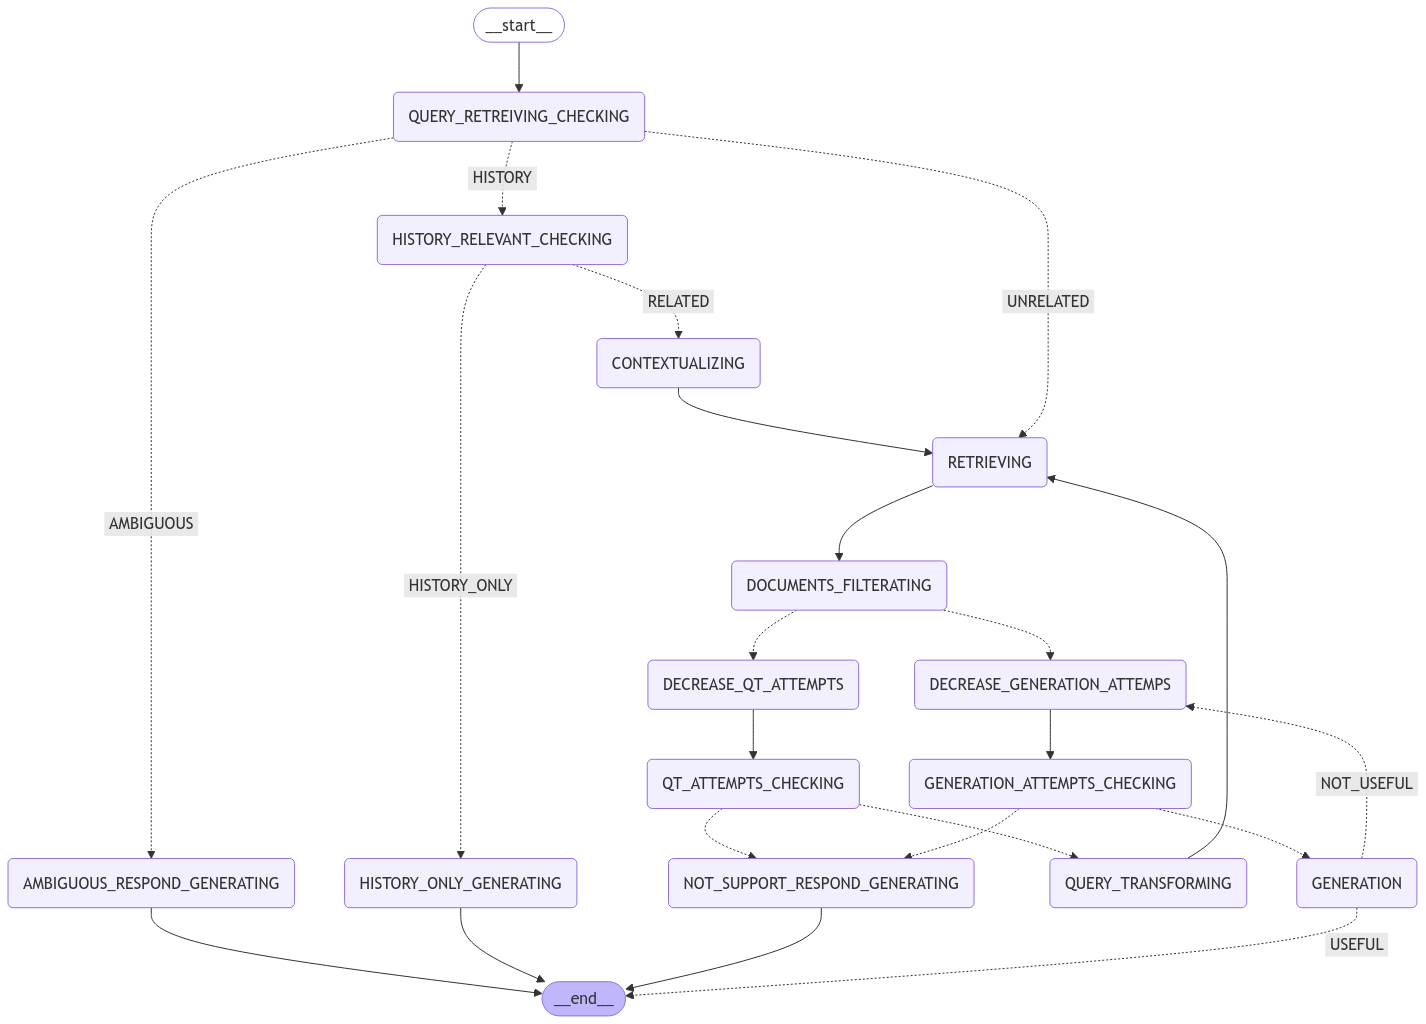

In [37]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

## Testing

In [38]:
from pprint import pprint
chat_history: BaseMessage = []

def chat_llm(query: str):
    inputs = {
    QUERY : query,
    CHAT_HISTORY: chat_history,
    GENERATION_ATTEMPTS: 3,
    QUERY_TRANSFORMATION_ATTEMPTS: 3
    }

    for output in app.stream(inputs):
        for key, value in output.items():
            pprint(f"Node '{key}:")
        pprint("\n---\n")

    chat_history.append(HumanMessage(content=f'{value[QUERY]}'))
    chat_history.append(AIMessage(content=f'{value[GENERATION]}'))

    pprint(value[GENERATION])

In [39]:
chat_llm("who is naruto?")

---CHECK QUERY RETREIVING---
---CHOOSE NEXT NODE TO CALL BASED ON QUERY RETREIVE GRADE---
---DECISION: QUERY IS NOT RELATED TO THE CHAT HISTORY---
"Node 'QUERY_RETREIVING_CHECKING:"
'\n---\n'
---RETRIEVE---
"Node 'RETRIEVING:"
'\n---\n'
---CHECK DOCUMENTS RELEVANCE TO QUERY---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: DECREASE GENERATION ATTEMPS---
"Node 'DOCUMENTS_FILTERATING:"
'\n---\n'
---DECREASE_generation_attempts---
GENERATION_ATTEMPTS: 3
"Node 'DECREASE_GENERATION_ATTEMPS:"
'\n---\n'
---CHECK_Generation_ATTEMPS_NUMBER---
---CHOOSE_NEXT_NODE_BASED_ON_GENERATION_ATTEMPS---
---DECISION: GENERATION
"Node 'GENERATION_ATTEMPTS_CHECKING:"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATION---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION VS QUERY
DECISION: GENERATION ADDRESSES QUERY---
"Node 'GENERATION:"
'\n---\n'
("Naruto Uzumaki is a shinobi from Konohagakure's Uzumak

In [40]:
chat_llm("who is his techer?")

---CHECK QUERY RETREIVING---
---CHOOSE NEXT NODE TO CALL BASED ON QUERY RETREIVE GRADE---
---DECISION: QUERY IS RELATED TO THE CHAT HISTORY---
"Node 'QUERY_RETREIVING_CHECKING:"
'\n---\n'
---CHECK CHAT HISTORY RELEVANT---
---CHOOSE NEXT NODE TO CALL BASED ON HISTORY RELEVANCY
---DECISION: QUERY IS RELATED TO THE CHAT HISTORY---
"Node 'HISTORY_RELEVANT_CHECKING:"
'\n---\n'
---CONTEXTUALIZE---
Kakashi is Naruto's teacher.
"Node 'CONTEXTUALIZING:"
'\n---\n'
---RETRIEVE---
"Node 'RETRIEVING:"
'\n---\n'
---CHECK DOCUMENTS RELEVANCE TO QUERY---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: DECREASE GENERATION ATTEMPS---
"Node 'DOCUMENTS_FILTERATING:"
'\n---\n'
---DECREASE_generation_attempts---
GENERATION_ATTEMPTS: 3
"Node 'DECREASE_GENERATION_ATTEMPS:"
'\n---\n'
---CHECK_Generation_ATTEMPS_NUMBER---
---CHOOSE_NEXT_NODE_BASED_ON_GENERATION_ATTEMPS---
---DECISION: GENERATION
"Node 'GENERATION_ATTEMPT

In [41]:
chat_llm("what is the name of his father?")

---CHECK QUERY RETREIVING---
---CHOOSE NEXT NODE TO CALL BASED ON QUERY RETREIVE GRADE---
---DECISION: QUERY IS RELATED TO THE CHAT HISTORY---
"Node 'QUERY_RETREIVING_CHECKING:"
'\n---\n'
---CHECK CHAT HISTORY RELEVANT---
---CHOOSE NEXT NODE TO CALL BASED ON HISTORY RELEVANCY
---DECISION: QUERY IS RELATED ONLY TO HISTORY---
"Node 'HISTORY_RELEVANT_CHECKING:"
'\n---\n'
---GENERATE HISTORY ONLY ANSWER---
"Node 'HISTORY_ONLY_GENERATING:"
'\n---\n'
("It seems we didn't discuss Naruto's father in our previous conversations. "
 "However, I can tell you that Naruto's father is the Fourth Hokage, Minato "
 'Namikaze. Would you like to know more about him?')


In [44]:
chat_llm("who is kakashi father")

---CHECK QUERY RETREIVING---
---CHOOSE NEXT NODE TO CALL BASED ON QUERY RETREIVE GRADE---
---DECISION: QUERY IS RELATED TO THE CHAT HISTORY---
"Node 'QUERY_RETREIVING_CHECKING:"
'\n---\n'
---CHECK CHAT HISTORY RELEVANT---
---CHOOSE NEXT NODE TO CALL BASED ON HISTORY RELEVANCY
---DECISION: QUERY IS RELATED ONLY TO HISTORY---
"Node 'HISTORY_RELEVANT_CHECKING:"
'\n---\n'
---GENERATE HISTORY ONLY ANSWER---
"Node 'HISTORY_ONLY_GENERATING:"
'\n---\n'
("It seems we didn't discuss Kakashi's father in our previous conversations. "
 "However, I can tell you that Kakashi's father is Sakumo Hatake, also known "
 'as the White Fang, a legendary ninja from the Hatake clan. Would you like to '
 'know more about him?')
